Klasifikasi gambar.

Data yang digunakan adalah data Intel Image Classification yang bersumber dari Kaggle https://www.kaggle.com/datasets/puneet6060/intel-image-classification

In [1]:
!pip install -q kaggle

In [2]:
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob as gb

import seaborn as sns

import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import Input, InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV3Small, MobileNetV2

# # Mengabaikan peringatan
# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

Data Preparation

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mochamadyusuf","key":"394412d90fa9ccf4d1d646d43d6da557"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d puneet6060/intel-image-classification
!unzip -qq intel-image-classification.zip

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 97% 335M/346M [00:02<00:00, 152MB/s]
100% 346M/346M [00:02<00:00, 137MB/s]


In [6]:
os.listdir('./')

['.config',
 'seg_pred',
 'kaggle.json',
 'seg_train',
 'seg_test',
 'intel-image-classification.zip',
 'sample_data']

Data Preprocessing

In [7]:
# Define training and test directories
TRAIN_DIR = "./seg_test/seg_test"
TEST_DIR = "./seg_train/seg_train"

train_buildings = os.path.join(TRAIN_DIR + '/buildings')
train_forest = os.path.join(TRAIN_DIR + '/forest')
train_glacier = os.path.join(TRAIN_DIR + '/glacier')
train_mountain = os.path.join(TRAIN_DIR + '/mountain')
train_sea = os.path.join(TRAIN_DIR + '/sea')
train_street = os.path.join(TRAIN_DIR + '/street')

test_buildings = os.path.join(TEST_DIR + '/buildings')
test_forest = os.path.join(TEST_DIR + '/forest')
test_glacier = os.path.join(TEST_DIR + '/glacier')
test_mountain = os.path.join(TEST_DIR + '/mountain')
test_sea = os.path.join(TEST_DIR + '/sea')
test_street = os.path.join(TEST_DIR + '/street')

print("Total buildings images in training set: ",len(os.listdir(train_buildings)))
print("Total forest images in training set: ",len(os.listdir(train_forest)))
print("Total glacier images in training set: ",len(os.listdir(train_glacier)))
print("Total mountain images in training set: ",len(os.listdir(train_mountain)))
print("Total sea images in training set: ",len(os.listdir(train_sea)))
print("Total street images in training set: ",len(os.listdir(train_street)))

print("Total buildings images in test set: ",len(os.listdir(test_buildings)))
print("Total forest images in test set: ",len(os.listdir(test_forest)))
print("Total glacier images in test set: ",len(os.listdir(test_glacier)))
print("Total mountain images in test set: ",len(os.listdir(test_mountain)))
print("Total sea images in test set: ",len(os.listdir(test_sea)))
print("Total street images in test set: ",len(os.listdir(test_street)))

Total buildings images in training set:  437
Total forest images in training set:  474
Total glacier images in training set:  553
Total mountain images in training set:  525
Total sea images in training set:  510
Total street images in training set:  501
Total buildings images in test set:  2191
Total forest images in test set:  2271
Total glacier images in test set:  2404
Total mountain images in test set:  2512
Total sea images in test set:  2274
Total street images in test set:  2382


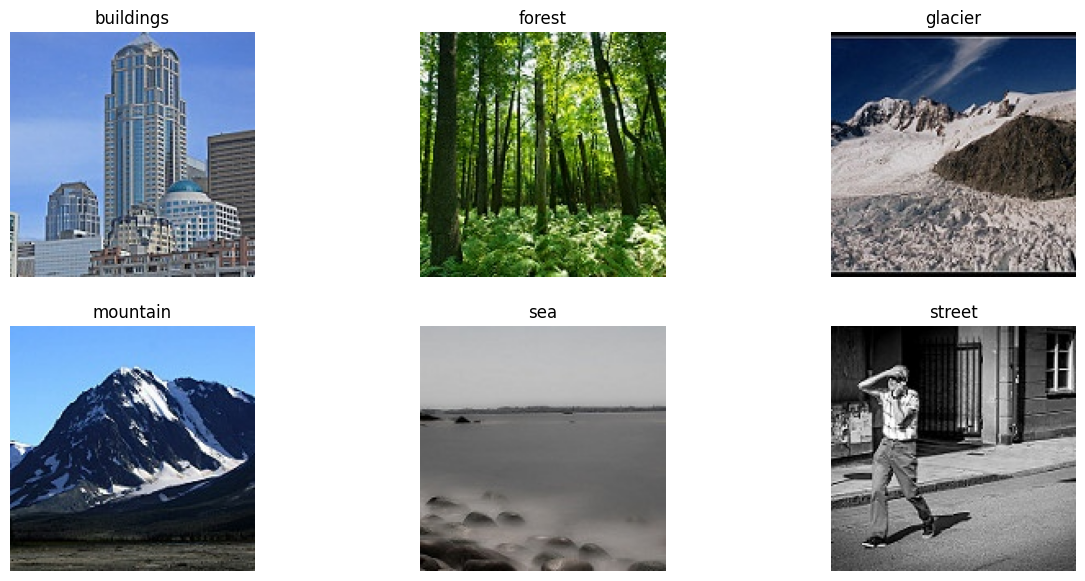

In [8]:
# Lihat gambar acak
def view_random_image(target_dir, target_class):
  random_image = random.sample(os.listdir(target_dir), 1)

  img = mpimg.imread(target_dir + "/" + random_image[0] )
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  return img
plt.figure(figsize = (15,7))
plt.subplot(2,3,1)
gambar = view_random_image(train_buildings, "buildings")
plt.subplot(2,3,2)
gambar = view_random_image(train_forest, "forest")
plt.subplot(2,3,3)
gambar = view_random_image(train_glacier, "glacier")
plt.subplot(2,3,4)
gambar = view_random_image(train_mountain, "mountain")
plt.subplot(2,3,5)
gambar = view_random_image(train_sea, "sea")
plt.subplot(2,3,6)
gambar = view_random_image(train_street, "street")

In [49]:
# Buat objek ImageDataGenerator yang menormalkan gambar
datagen = ImageDataGenerator(rescale=1/255, validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(150,150),
                                              color_mode="rgb",
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(TEST_DIR,
                                                   batch_size=32,
                                                   target_size=(150,150),
                                                   color_mode="rgb",
                                                   class_mode='categorical',
                                                   subset='validation',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=32,
                                                  target_size=(150,150),
                                                  color_mode="rgb",
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 2402 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 14034 images belonging to 6 classes.


Modelling

In [43]:
# Memuat model MobileNetV2 yang telah terlatih
pre_trained_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(150, 150, 3))
pre_trained_model.trainable = False

# Membuat model Sequential dan menambahkan MobileNetV2 sebagai base
model = Sequential()

# Menambahkan pre-trained MobileNetV2
model.add(pre_trained_model)

# Menambahkan lapisan Conv2D dan Pooling tambahan
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation='softmax'))

<ipython-input-43-28b4c0ea7687>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  pre_trained_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(150, 150, 3))


In [44]:
# Membuat optimizer
int_lr = 1e-4

model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='binary_crossentropy',
                metrics=['accuracy'])

In [45]:
# Callback untuk menghentikan pelatihan jika akurasi dan akurasi validasi di atas 97%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.97 and logs.get('val_accuracy')>0.97):
      print("\nAkurasi dan validation akurasi telah mencapai >97%!")
      self.model.stop_training = True

callbacks = myCallback()

In [50]:
count_buildings = len(os.listdir(train_buildings))
count_forest = len(os.listdir(train_forest))
count_glacier = len(os.listdir(train_glacier))
count_mountain = len(os.listdir(train_mountain))
count_sea = len(os.listdir(train_sea))
count_street = len(os.listdir(train_street))

weight_0 = (1 / count_buildings) * (count_buildings + count_forest + count_glacier + count_mountain + count_sea + count_street) / 2.0
weight_1 = (1 / count_forest) * (count_buildings + count_forest + count_glacier + count_mountain + count_sea + count_street) / 2.0
weight_2 = (1 / count_glacier) * (count_buildings + count_forest + count_glacier + count_mountain + count_sea + count_street) / 2.0
weight_3 = (1 / count_mountain) * (count_buildings + count_forest + count_glacier + count_mountain + count_sea + count_street) / 2.0
weight_4 = (1 / count_sea) * (count_buildings + count_forest + count_glacier + count_mountain + count_sea + count_street) / 2.0
weight_5 = (1 / count_street) * (count_buildings + count_forest + count_glacier + count_mountain + count_sea + count_street) / 2.0

class_weights = {0 : weight_0, 1 : weight_1, 2 : weight_2, 3 : weight_3, 4 : weight_4, 5 : weight_5}

%time

# Fitting / training model
history = model.fit(train_generator,
                        epochs=5,
                        validation_data=validation_generator,
                        callbacks=[callbacks],
                        class_weight = class_weights)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs
Epoch 1/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 13s 169ms/step - accuracy: 0.9859 - loss: 0.0520 - val_accuracy: 0.8766 - val_loss: 0.1758
Epoch 2/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 0.9873 - loss: 0.0352 - val_accuracy: 0.8927 - val_loss: 0.1739
Epoch 3/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9944 - loss: 0.0171 - val_accuracy: 0.8738 - val_loss: 0.2116
Epoch 4/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.9875 - loss: 0.0350 - val_accuracy: 0.8884 - val_loss: 0.2005
Epoch 5/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.9896 - loss: 0.0239 - val_accuracy: 0.8848 - val_loss: 0.1887


Evaluasi dan Visualisasi

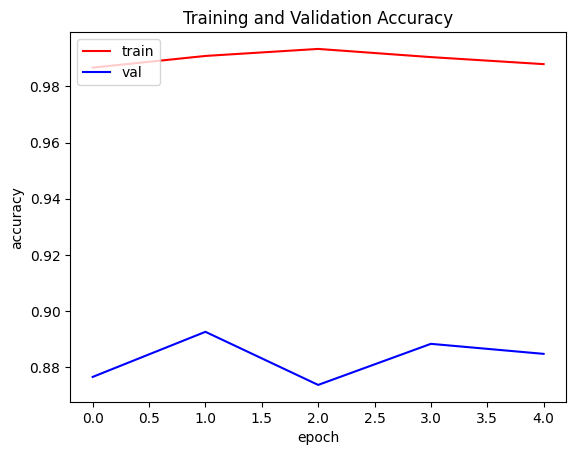

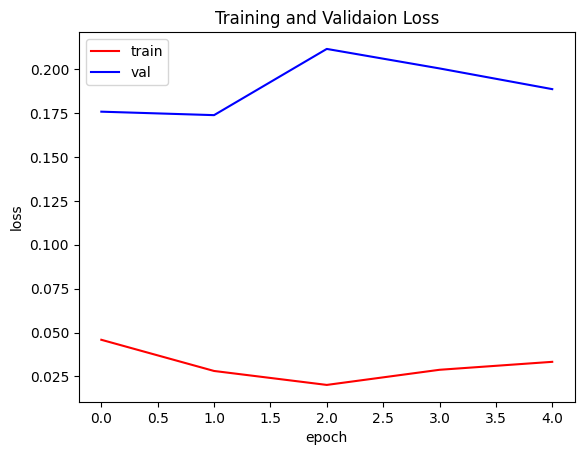

In [51]:
# menampilkan grafik hasil dari pelatihan model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()



              precision    recall  f1-score   support

   buildings     0.8663    0.9343    0.8990      2191
      forest     0.9807    0.9833    0.9820      2271
     glacier     0.7864    0.8057    0.7960      2404
    mountain     0.7983    0.8463    0.8216      2512
         sea     0.9528    0.8698    0.9094      2274
      street     0.9380    0.8631    0.8990      2382

    accuracy                         0.8819     14034
   macro avg     0.8871    0.8838    0.8845     14034
weighted avg     0.8851    0.8819    0.8826     14034



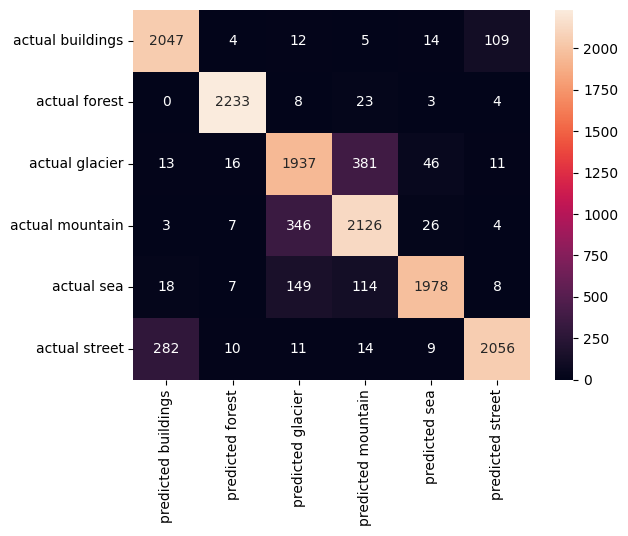

In [52]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Melakukan prediksi menggunakan model yang sudah dilatih
test_generator.reset()

preds_1 = model.predict(test_generator, verbose=0)
preds_1 = preds_1.copy()
preds_1 = preds_1.argmax(axis=1)

# Definisikan label sesuai kelas (0: buildings, 1: forest, 2: glacier, 3: mountain, 4: sea, 5: street)
labels = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, preds_1, labels=[0, 1, 2, 3, 4, 5]),
                  index=["actual buildings", "actual forest", "actual glacier",
                         "actual mountain", "actual sea", "actual street"],
                  columns=["predicted buildings", "predicted forest", "predicted glacier",
                           "predicted mountain", "predicted sea", "predicted street"])

# Visualisasikan confusion matrix
sns.heatmap(cm, annot=True, fmt="d")

print("\n")
print(classification_report(y_true=test_generator.classes, y_pred=preds_1, target_names=labels, digits=4))

Konversi Model

In [53]:
# hapus folder saved_model, tfjs_model, tflite, file model.h5, dan model.zip
!rm -rf saved_model tfjs_model tflite model.h5 model.zip

In [54]:
# Konversi Format SavedModel
model.export("saved_model/intel_model/1")

Saved artifact at 'saved_model/intel_model/1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_872')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  138322646801616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138322646802960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138322646803344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138322646803152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138322646801040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138322646804496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138322646804880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138322646805264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138322646805072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138322646802384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1

In [55]:
# Konversi Tensorflow.js
model.save("model.h5")

!pip install tensorflowjs
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 94.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 26.7 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
2025-02-19 01:43:44.157114: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739929424.177668   10555 cuda_dnn.cc:8310] Unable to regis

In [56]:
# Konversi Tensorflow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
tflite_model_file = pathlib.Path("model.tflite")
tflite_model_file.write_bytes(tflite_model)

Saved artifact at '/tmp/tmpk8tarkhu'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_872')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  138322646801616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138322646802960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138322646803344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138322646803152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138322646801040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138322646804496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138322646804880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138322646805264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138322646805072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138322646802384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1383226468

10451140

In [57]:
# Definisikan label sesuai kelas
labels = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

with open('label.txt', 'w') as f:
  for label in labels:
    f.write(label + '\n')

In [58]:
# membuat folder tflite dan memindahkan model.tflite dan label.txt ke dalamnya
!mkdir tflite
!mv model.tflite label.txt tflite/

In [59]:
!pip freeze > requirements.txt

In [60]:
# buat folder dan file yang dibutuhkan menjadi zip agar mudah didownload
!zip -r model.zip saved_model tfjs_model tflite model.h5 requirements.txt

  adding: saved_model/ (stored 0%)
  adding: saved_model/intel_model/ (stored 0%)
  adding: saved_model/intel_model/1/ (stored 0%)
  adding: saved_model/intel_model/1/saved_model.pb (deflated 91%)
  adding: saved_model/intel_model/1/fingerprint.pb (stored 0%)
  adding: saved_model/intel_model/1/variables/ (stored 0%)
  adding: saved_model/intel_model/1/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: saved_model/intel_model/1/variables/variables.index (deflated 78%)
  adding: saved_model/intel_model/1/assets/ (stored 0%)
  adding: tfjs_model/ (stored 0%)
  adding: tfjs_model/model.json (deflated 97%)
  adding: tfjs_model/group1-shard2of3.bin (deflated 7%)
  adding: tfjs_model/group1-shard1of3.bin (deflated 7%)
  adding: tfjs_model/group1-shard3of3.bin (deflated 7%)
  adding: tflite/ (stored 0%)
  adding: tflite/model.tflite (deflated 7%)
  adding: tflite/label.txt (deflated 4%)
  adding: model.h5 (deflated 10%)
  adding: requirements.txt (deflated 57%)
